# Asset Pricing

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import fsolve
from scipy.optimize import broyden1
from scipy.optimize import minimize
from scipy import optimize as opt
import math
import scipy
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')
from scipy import stats
import sympy as sy

### Problem 1

In [24]:
### Use data cleaning from scott

def convert_to_daily_with_ffill(df):
    '''convert_to_daily_with_ffill

    This method converts a dataframe to have a daily index and forward fills all of the missing days.  Useful for converting (for example) stock market data to quarterly data when the quarterly return is wanted.

    :param df: a pandas.DataFrame to be converted
    :returns: a pandas.DataFrame that has been converted
    '''

    new_idx = pd.date_range('01-01-1950', '07-01-2018')
    df = df.reindex(new_idx)
    df = df.fillna(method="ffill")
    return df

start = datetime.datetime(1950, 1,1)
end = datetime.datetime(2018, 7, 1)
rpce = web.DataReader('PCECC96', 'fred', start, end)
w5000 = web.DataReader('WILL5000INDFC', 'fred', start, end)
w5000 = convert_to_daily_with_ffill(w5000)
gdef = web.DataReader('GDPDEF', 'fred', start, end)
tb = web.DataReader('TB3MS', 'fred', start, end)

df = pd.DataFrame(columns=['rpce', 'w5000', 'tb', 'gdef'], index = rpce.index)
df['rpce'] = rpce
df['w5000'] = w5000
df['gdef'] = gdef
df['inf'] = df['gdef']/df['gdef'].shift(1)
#df['w5000_d'] = df['w5000']/df['inf']      # Deflated asset price returns
df['R_nom'] = df['w5000'].shift(-1)/df['w5000']
df['R'] = df['R_nom']/df['inf']# Returns to asset prices
df['tb'] = tb/100. + 1    # Convert to percentage and make a gross return
df['rpce_1'] = rpce.shift(-1)
df  = df.dropna(axis=0)   # Drop NaNs
df.head(10)

,rpce,w5000,tb,gdef,inf,R_nom,R,rpce_1
DATE,,,,,,,,
1971-01-01,2968.902,1.00,1.0444,23.536,1.015270,1.120000,1.103154,2996.124
1971-04-01,2996.124,1.12,1.0386,23.846,1.013171,1.008929,0.995812,3020.036
1971-07-01,3020.036,1.13,1.0540,24.088,1.010148,0.991150,0.981193,3070.230
1971-10-01,3070.230,1.12,1.0446,24.288,1.008303,1.053571,1.044896,3110.801
1972-01-01,3110.801,1.18,1.0338,24.664,1.015481,1.067797,1.051518,3170.159
1972-04-01,3170.159,1.26,1.0371,24.815,1.006122,1.007937,1.001803,3219.095
1972-07-01,3219.095,1.27,1.0398,25.048,1.009389,1.023622,1.014100,3294.606
1972-10-01,3294.606,1.30,1.0474,25.366,1.012696,1.069231,1.055826,3354.764
1973-01-01,3354.764,1.39,1.0541,25.661,1.011630,0.920863,0.910277,3353.357


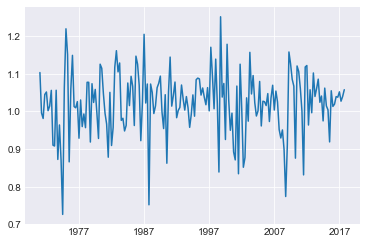

In [25]:
plt.plot(df['R'])

#### 1.1


In [13]:
def sdf(gamma):
    m_tp1 = 0.99*(df['rpce_1']**(-gamma))/(df['rpce']**(-gamma))
    return m_tp1

In [17]:
def err_1(gamma):
    cov = sdf(gamma).cov(df['R'])
    error = 1 - cov - (sdf(gamma).mean())*(df['R'].mean())
    return error

In [27]:
opt.root(err_1, 1.0)

    fjac: array([[-1.]])
     fun: 0.0
 message: 'The solution converged.'
    nfev: 6
     qtf: array([1.24567023e-13])
       r: array([-0.00758188])
  status: 1
 success: True
       x: array([1.3966694])

#### 1.3

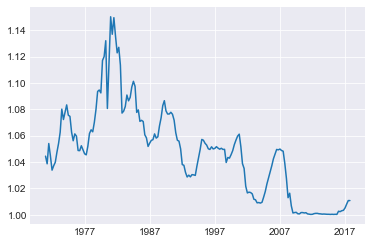

In [28]:
plt.plot(df['tb'])

In [39]:
def err_3(gamma):
    error = df['tb'] - 1/sdf(gamma)
    errorabs = np.abs(error)
    dist = errorabs.sum()
    return dist

In [41]:
opt.minimize(err_3, 0.8, method = 'Nelder-Mead')

 final_simplex: (array([[2.71890625],
       [2.71882813]]), array([5.74803343, 5.74803459]))
           fun: 5.748033431193163
       message: 'Optimization terminated successfully.'
          nfev: 38
           nit: 19
        status: 0
       success: True
             x: array([2.71890625])

#### 1.4

In [67]:
def sdf(gamma, beta):
    m_tp1 = beta*(df['rpce_1']**(-gamma))/(df['rpce']**(-gamma))
    return m_tp1

In [68]:
def err_4_1(params):
    gamma, beta = params
    cov = sdf(gamma, beta).cov(df['R'])
    error_1 = 1 - cov - (sdf(gamma, beta).mean())*(df['R'].mean())
    
    error_temp = df['tb'] - 1/sdf(gamma, beta)
    errorabs = np.abs(error_temp)
    error_2 = errorabs.sum()
    
    error = np.zeros(2)
    error[0] = error_1
    error[1] = error_2
    
    return error

In [69]:
def criterion(params, *args):
    gamma, beta = params
    W = args
    error = err_4_1(params)
    crit_val = error.T @ W @ error
    return crit_val

In [72]:
W_4 = np.eye(2)
params_init = np.array([5, 0.5])
gmm_args = W_4

In [73]:
opt.minimize(criterion, params_init, args = gmm_args,
            method = 'L-BFGS-B', bounds = ((1e-10, None), (1e-10, 1)))

      fun: array([25.03196971])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.4755158 , 87.66608488])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 324
      nit: 22
   status: 0
  success: True
        x: array([0.24393552, 0.9560938 ])

In [77]:
n = 60
N = 5
gamma_grid = np.linspace(0, 5, n)
beta_grid = np.linspace(0.95, 0.99, N)
gmm_values = np.zeros((n, N))
for i in range(n):
    for j in range(N):
        gmm_values[i, j] = criterion((gamma_grid[i], beta_grid[j]), W_4)

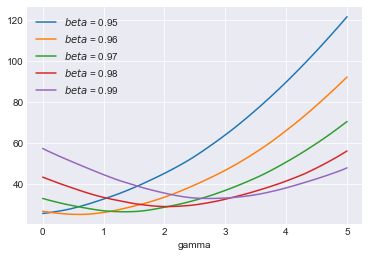

In [82]:
for j in range(N):
    plt.plot(gamma_grid, gmm_values[:, j], label=rf'$beta$ = {beta_grid[j]:.2f}')
plt.xlabel('gamma')
plt.legend()
plt.show()